In [1]:
# prerequisites
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image

bs = 100
# MNIST Dataset
train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=False)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=bs, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=bs, shuffle=False)

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [3]:
n_x = 28*28 #input features

In [4]:
class VAE(nn.Module):
    def __init__(self, x_dim, h_dim1, h_dim2, z_dim):
        super(VAE, self).__init__()
        
        # encoder part
        self.fc1 = nn.Linear(x_dim, h_dim1)
        self.fc2 = nn.Linear(h_dim1, h_dim2)
        self.fc31 = nn.Linear(h_dim2, z_dim)
        self.fc32 = nn.Linear(h_dim2, z_dim)
        # decoder part
        self.fc4 = nn.Linear(z_dim, h_dim2)
        self.fc5 = nn.Linear(h_dim2, h_dim1)
        self.fc6 = nn.Linear(h_dim1, x_dim)
        
    def encoder(self, x):
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))
        return self.fc31(h), self.fc32(h) # mu, log_var
    
    def sampling(self, mu, log_var):
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu) # return z sample
        
    def decoder(self, z):
        h = F.relu(self.fc4(z))
        h = F.relu(self.fc5(h))
        return torch.sigmoid(self.fc6(h)) 
    
    def forward(self, x):
        mu, log_var = self.encoder(x.view(-1, n_x))
        z = self.sampling(mu, log_var)
        return self.decoder(z), mu, log_var

# build model
vae = VAE(x_dim=n_x, h_dim1= 512, h_dim2=256, z_dim=2).to(device)

In [5]:
vae

VAE(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc31): Linear(in_features=256, out_features=2, bias=True)
  (fc32): Linear(in_features=256, out_features=2, bias=True)
  (fc4): Linear(in_features=2, out_features=256, bias=True)
  (fc5): Linear(in_features=256, out_features=512, bias=True)
  (fc6): Linear(in_features=512, out_features=784, bias=True)
)

In [6]:
optimizer = optim.Adam(vae.parameters())
# return reconstruction error + KL divergence losses
def loss_function(recon_x, x, mu, log_var):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, n_x), reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return BCE + KLD

In [7]:
def train(epoch,average_loss):
    vae.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        
        recon_batch, mu, log_var = vae(data)
        loss = loss_function(recon_batch, data, mu, log_var)
        
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item() / len(data)))
    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(train_loader.dataset)))
    average_loss.append(train_loss / len(train_loader.dataset))
    return average_loss

In [8]:
def test(val_loss):
    vae.eval()
    test_loss= 0
    with torch.no_grad():
        for data, _ in test_loader:
            data = data.to(device)
            recon, mu, log_var = vae(data)
            
            # sum up batch loss
            test_loss += loss_function(recon, data, mu, log_var).item()
        
    test_loss /= len(test_loader.dataset)
    val_loss.append(test_loss)
    print('====> Test set loss: {:.4f}'.format(test_loss))
    return val_loss

In [9]:
average_loss= []
val_loss= []
n_epoch = 1000
for epoch in range(1, n_epoch+1):
    train(epoch,average_loss)
    test(val_loss)
    if epoch == 1 or epoch %10 == 0:
        with torch.no_grad():
            z = torch.randn(100, 2).to(device)
            sample = vae.decoder(z).to(device)
            filename = './output_bs100/VAE_bs100_%04d_epoch.png' %epoch      
            save_image(sample.view(100, 1, 28, 28), filename)

Streaming output truncated to the last 5000 lines.
Train Epoch: 376 [0/60000 (0%)]	Loss: 138.393828
Train Epoch: 376 [10000/60000 (17%)]	Loss: 128.044209
Train Epoch: 376 [20000/60000 (33%)]	Loss: 130.481709
Train Epoch: 376 [30000/60000 (50%)]	Loss: 134.319111
Train Epoch: 376 [40000/60000 (67%)]	Loss: 129.805576
Train Epoch: 376 [50000/60000 (83%)]	Loss: 129.103643
====> Epoch: 376 Average loss: 128.2552
====> Test set loss: 140.2485
Train Epoch: 377 [0/60000 (0%)]	Loss: 131.339482
Train Epoch: 377 [10000/60000 (17%)]	Loss: 123.975576
Train Epoch: 377 [20000/60000 (33%)]	Loss: 128.247568
Train Epoch: 377 [30000/60000 (50%)]	Loss: 135.240547
Train Epoch: 377 [40000/60000 (67%)]	Loss: 126.106094
Train Epoch: 377 [50000/60000 (83%)]	Loss: 131.026240
====> Epoch: 377 Average loss: 127.9910
====> Test set loss: 139.9285
Train Epoch: 378 [0/60000 (0%)]	Loss: 121.646689
Train Epoch: 378 [10000/60000 (17%)]	Loss: 131.314316
Train Epoch: 378 [20000/60000 (33%)]	Loss: 130.070088
Train Epoch: 3

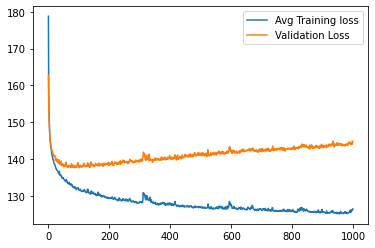

In [10]:
import matplotlib
import matplotlib.pyplot as plt
# plot and save the training and validation loss
plt.figure()
plt.plot(average_loss, label='Avg Training loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend()
plt.savefig('./output_bs100/VAE_loss.png')

In [11]:
!zip -r /content/output.zip /content/output_bs100

  adding: content/output_bs100/ (stored 0%)
  adding: content/output_bs100/VAE_bs100_0180_epoch.png (deflated 3%)
  adding: content/output_bs100/VAE_bs100_0200_epoch.png (deflated 4%)
  adding: content/output_bs100/VAE_bs100_0630_epoch.png (deflated 4%)
  adding: content/output_bs100/VAE_bs100_0600_epoch.png (deflated 4%)
  adding: content/output_bs100/VAE_bs100_0590_epoch.png (deflated 4%)
  adding: content/output_bs100/VAE_bs100_0790_epoch.png (deflated 4%)
  adding: content/output_bs100/VAE_bs100_0510_epoch.png (deflated 4%)
  adding: content/output_bs100/VAE_bs100_0620_epoch.png (deflated 4%)
  adding: content/output_bs100/VAE_bs100_0670_epoch.png (deflated 4%)
  adding: content/output_bs100/VAE_bs100_0410_epoch.png (deflated 4%)
  adding: content/output_bs100/VAE_bs100_0930_epoch.png (deflated 4%)
  adding: content/output_bs100/VAE_bs100_0020_epoch.png (deflated 3%)
  adding: content/output_bs100/VAE_bs100_0310_epoch.png (deflated 4%)
  adding: content/output_bs100/VAE_bs100_0160_

In [12]:
from google.colab import files
files.download("/content/output.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>